# T-Cell Type Clustering
Project mentor: Ravichandran Prashanthi

Wenqian Xu <wxu51@jh.edu>, Ruzhang Zhao <rzhao24@jh.edu>, Guangwei Zhou <gzhou11@jh.edu>

https://github.com/GZHOUW/T-Cell-Type-Clustering

# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# Outline and Deliverables

List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.

If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.

### Uncompleted Deliverables
1. 


### Completed Deliverables
1. "Must complete #1": Preprocess the data with gene and cell filtering and implement Kmeans method on simple dataset as baseline. ["Pre-processing"](#scrollTo=zFq-_D0khnhh&line=10&uniqifier=1).
2. "Must complete #2": Apply PCA and autoencoder to get low dimensional embedding on the whole dataset, respectively. ["Pre-processing"]
3. "Must complete #3": Apply the unsupervised clustering learning methods (Kmeans and spectral clustering) to separate cells into different clusters. ["Methods"]
4. "Expect to complete #1": Perform optimization of clustering for different methods.
5. "Expect to complete #2": Perform evaluation of clustering for different methods.
6. "Expect to complete #3": Evaluation and corresponding analysis are carried out for different dimensions of PCs and autoencoder low dimensional embeddings.
7. "Would like to complete #1": Use clustering results to perform cluster based imputation
8. "Would like to complete #2": Based on imputation results, use Wilcoxin rank sum test to check if there is differentially expressed genes between differentclusters.

### Additional Deliverables
1. Try with different component numbers in PCA can investigate how the result is affected. 

# Preliminaries

This project aims to solve the problems of distinguishing between different types of T-cells and understanding their difference in genes. Specifically, we would like to group together each type of T-cell with their genes as features. A major real-world implication of this task is the single cell genomics technology that is able to provide many valuable insights on cell level gene expression. In fact, the Next-Generation Sequencing (NGS) platform is making rapid progress in understanding complex biological systems in recent years.

The completion of this project involves several topics that we have covered in lectures, breakouts, and homeworks. The unvupervised learing method we chose to use are k-means clustering and spectral clustering, which are covered in the clustering lecture. During pre-processing, we applied dimentionality reduction method PCA algorithm, which was covered in dimentionality reduction lecture. We also implemented auto-encoder, which was not covered in class. This problem is unique because their have been little instances where these particular T-cells are being clustered with the approaches we decided to use. 


There are some ethical problems related to this project. First, since the genomics data are from human subjects, the data might have ethical concerns. Second, we need to avoid bias in the pre-procesing section.  

## Dataset(s)

The dataset we used in this project is a single cell genomics dataset. We focused on the single cell RNA expression data of 5 types of T-cell,including cytotoxic T cell, naive cytotoxic T cell, memory T cell, regulatory T cell and naive T cell. 

The dataset is from a website of a company names 10X Genomics: https://www.10xgenomics.com/resources/datasets/. This company researches the topics including oncology, immunology, and neuroscience. According to the website, the data were collected from voluntary human donors. We chose this data because the difference between T cell and other cell type are easier to capture.

The dataset genes as features and cells as samples. The input of our dataset is the gene expression valuefor a certain gene in a cell. The output is the label for the cell, which is divided into 5 different T cell types. The selected dataset has more than 50,000 genes and more than 60,000 cells, where each cell type, among a total of 6, has more than 10,000 cells. 

Before pre-processing, we performed gene filtration and cell filtration. To filter cells, we retain cells with positive expression in at least 500 genes. To filter genes, we only keep genes that are expressed in at least 0.1% of cells. This gives us over 20,000 genes and over 30,000 cells. Next, we compute the mean and variance of each gene, and then fit locally weighted polynomial regression using variance against mean. We use 2000 most variable genes to be our features and keep the cell proportion among 6 cell types to be similar with original data. Finally, our dataset has 2000 features and 6556 cells.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/ml-final-proj

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/ml-final-proj


In [ ]:
# Setting environment
%pylab inline
%tensorflow_version 1.x

Populating the interactive namespace from numpy and matplotlib
TensorFlow 1.x selected.


In [ ]:
# Load your data and print 2-3 examples
import pandas as pd
import numpy as np

url_pbmc = 'https://raw.githubusercontent.com/RuzhangZhao/Genomic-Data/main/PBMC_final'+str(1)+'.csv'
data = pd.read_csv(url_pbmc,index_col=0)
for i in range(2,7):
    url_pbmc = 'https://raw.githubusercontent.com/RuzhangZhao/Genomic-Data/main/PBMC_final'+str(i)+'.csv'
    data_tmp = pd.read_csv(url_pbmc,index_col=0)
    data = pd.concat([data,data_tmp],axis=1)

data_label = pd.read_csv('https://raw.githubusercontent.com/RuzhangZhao/Genomic-Data/main/PBMC_final_label.csv')
data = data.to_numpy()
data = data.astype('float32') 
data_label = data_label.to_numpy()
data_label = data_label[:,1]

data_b = pd.DataFrame(data=data.T[0:,0:], index=[i for i in range(data.T.shape[0])], 
                          columns=['f'+str(i) for i in range(data.T.shape[1])])
print(f"Our original dataset has {data_b.shape[1]} features and {data_b.shape[0]} examples")
print(f"Here are few data of our example: \n{data_b}")

Our original dataset has 11976 features and 20733 examples
Here are few data of our example: 
        f0   f1   f2   f3   f4  ...  f11971  f11972  f11973  f11974  f11975
0      0.0  0.0  0.0  0.0  0.0  ...     0.0     4.0     0.0     0.0     0.0
1      0.0  0.0  0.0  0.0  1.0  ...     0.0     4.0     0.0     1.0     0.0
2      0.0  0.0  0.0  0.0  0.0  ...     1.0     4.0     0.0     0.0     0.0
3      0.0  0.0  0.0  0.0  0.0  ...     0.0     4.0     0.0     0.0     0.0
4      0.0  0.0  0.0  0.0  0.0  ...     0.0     1.0     0.0     0.0     0.0
...    ...  ...  ...  ...  ...  ...     ...     ...     ...     ...     ...
20728  0.0  0.0  0.0  0.0  0.0  ...     0.0     1.0     0.0     0.0     0.0
20729  0.0  0.0  0.0  0.0  0.0  ...     0.0     2.0     0.0     0.0     0.0
20730  0.0  0.0  0.0  0.0  0.0  ...     0.0     4.0     0.0     0.0     0.0
20731  0.0  0.0  0.0  0.0  0.0  ...     0.0     3.0     0.0     0.0     0.0
20732  0.0  0.0  0.0  0.0  0.0  ...     0.0     1.0     0.0     0.0   

## Pre-processing

For data pre-processing, we mainly focused on "feature extraction" because this is an unsupervised machine learning task.

Before implementing feature extraction, we used one simple feature selection method to filter the data set by thresholding the variance. For our baseline model, we choose 100 features and all examples as our training set. After that, we implemented two different feature extraction of dataset preprocessing methods, PCA and Autoencoder. Autoencoder is a great extension of non-linear data processing analysis. There have been plenty of successful implementation of autoencoders in the filed of single cell genomics. It is reasonable to apply autoencoder because the scRNAseq is believed to have low dimensional representation, like what we usually assume for high dimensional data. Accordingly, we built an autoencoder to capture the low dimensional representation of the data, in order to achieve dimensional reduction.

Principal component analysis (PCA) is a common used data processing method for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. We carried out the PCA method as the comparison with Autoencoder. It allowed us to see the difference between linear embedding and non-linear embedding. For PCA, the only hyperparameter we tuned was the number of components, or the number of principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by variance, and we wanted to reduce the dimension of data. In order to choose the number of components that produces the best results, we tried 90 difference value from 10 to 100. In the end, we chose 20 as the number of components. 

Since we performed unsupervised learning, there are no labels involved. We did not manually make the number of each type of T-cell the same (balance) in order to keep the real proportion of the cells in human body. As for missing data and outliers, we checked our data and found that there are no missing data, nor significant outliers. Therefore, we did not do anything about these in the preprocessing. We did perform imputation in later section to deal with inappropriate data. 


In [ ]:
# Visualize the distribution of your data before pre-processing.
## Show balance of our original data set
for i in np.unique(data_label):
    print(f'{len(data_label[data_label==i])} examples of class {i}')

6363 examples of class Cyto
5156 examples of class Memory
1703 examples of class Naive
5093 examples of class NaiveCyto
2418 examples of class Regulatory


In [ ]:
## Compute summary statistics across the features in the data

df_X_train = pd.DataFrame(data=data.T[0:,0:], index=[i for i in range(data.T.shape[0])], 
                          columns=['f'+str(i) for i in range(data.T.shape[1])])
print(df_X_train.describe(include='all').transpose())


          count      mean       std  min  25%  50%  75%   max
f0      20733.0  0.001109  0.033291  0.0  0.0  0.0  0.0   1.0
f1      20733.0  0.001543  0.039253  0.0  0.0  0.0  0.0   1.0
f2      20733.0  0.001109  0.033292  0.0  0.0  0.0  0.0   1.0
f3      20733.0  0.009405  0.097035  0.0  0.0  0.0  0.0   2.0
f4      20733.0  0.065934  0.266370  0.0  0.0  0.0  0.0   5.0
...         ...       ...       ...  ...  ...  ...  ...   ...
f11971  20733.0  0.025129  0.164929  0.0  0.0  0.0  0.0   5.0
f11972  20733.0  3.798823  2.623155  0.0  2.0  3.0  5.0  31.0
f11973  20733.0  0.007283  0.085591  0.0  0.0  0.0  0.0   2.0
f11974  20733.0  0.033859  0.183542  0.0  0.0  0.0  0.0   2.0
f11975  20733.0  0.036705  0.194834  0.0  0.0  0.0  0.0   3.0

[11976 rows x 8 columns]


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

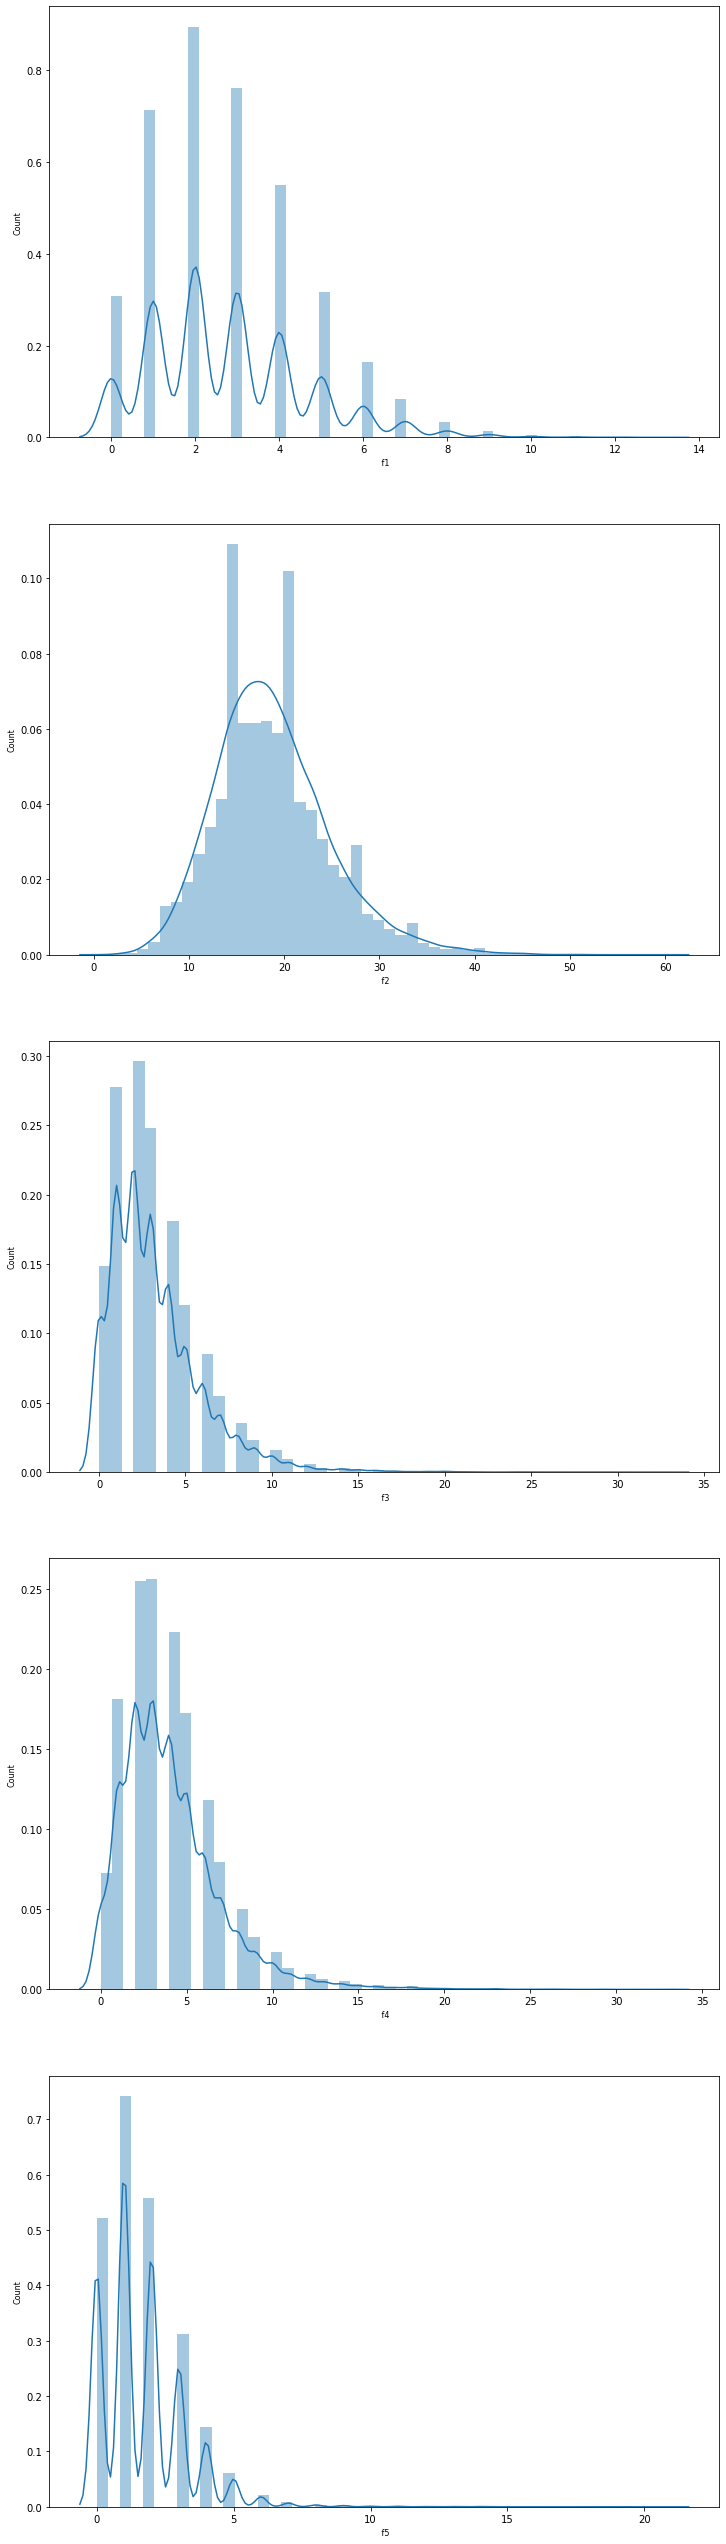

In [ ]:
## Visualize the histograms and the estimated PDF of any 5 features with less sparseness
import seaborn as sns

Sparseness = []
X_train_array = df_X_train.to_numpy()
for i in range(X_train_array.shape[1]):
    sparseness = 1.0 - (np.count_nonzero(X_train_array.T[i]) / float(X_train_array.T[i].size))
    Sparseness.append(sparseness)

listf = []
for j in range(len(Sparseness)):
    if Sparseness[j] < 0.29:
        listf.append(X_train_array.T[j])
      
features = ["f1", "f2", "f3", "f4", "f5"]
fig,  ax = plt.subplots(5, figsize=(12,46))
for i, feature_name in enumerate(list(features)):
    sns.distplot(listf[i], hist=True, ax=ax[i])
    ax[i].set_ylabel('Count', fontsize=8)
    ax[i].set_xlabel(" {}".format(feature_name), fontsize=8)
plt.show()

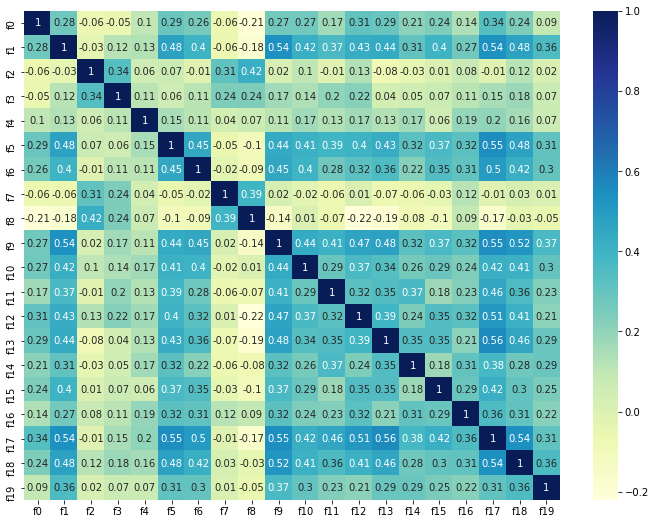

In [ ]:
## Plot heatmap of the features of a certain subset
X_train_sub = np.zeros([20,500])
for i in range(X_train_sub.shape[0]):
    for j in range(X_train_sub.shape[1]):
        X_train_sub[i][j] = listf[i][j]
X_train_sub = X_train_sub.T

df_X_train_sub = pd.DataFrame(data=X_train_sub[0:,0:], index=[i for i in range(X_train_sub.shape[0])], 
                          columns=['f'+str(i) for i in range(X_train_sub.shape[1])])

plt.figure(figsize=(12, 9));
correlation_matrix = df_X_train_sub.corr().round(2);
sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True);
plt.show()

In [ ]:
# Feature selection  
## Log normalization
data = np.log1p(data/data.sum(axis=0))
from statsmodels.nonparametric.smoothers_lowess import lowess
## Find Highly Variable Gene using lowess 
lowess_res = lowess(data.var(axis=1),data.mean(axis=1),return_sorted=False)
hvg_index = lowess_res.argsort()[-2000:][::-1]
data = data[hvg_index]
data_ori = data

## Scale data 
from sklearn import preprocessing
data = preprocessing.scale(data,axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [ ]:
# Feature extraction
## PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
extend_data_pca = pca.fit_transform(data.T)
print(f"Shape of data set before PCA: {data.T.shape}")
print(f"Shape of data set after PCA: {extend_data_pca.shape}")


Shape of data set before PCA: (20733, 2000)
Shape of data set after PCA: (20733, 20)


In [ ]:
## Autoencoder
from __future__ import division, print_function, absolute_import
import tensorflow as tf
n_input = 2000
X = tf.placeholder("float", [None, n_input])

n_hidden_1 = 500
n_hidden_2 = 128
n_hidden_3 = 64
n_hidden_4 = 20
weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1],)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],)),
    'encoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3],)),
    'encoder_h4': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4],)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_hidden_4, n_hidden_3],)),
    'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_2],)),
    'decoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1],)),
    'decoder_h4': tf.Variable(tf.truncated_normal([n_hidden_1, n_input],)),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'encoder_b4': tf.Variable(tf.random_normal([n_hidden_4])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b3': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b4': tf.Variable(tf.random_normal([n_input])),
}

def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    layer_4 = tf.add(tf.matmul(layer_3, weights['encoder_h4']),
                                    biases['encoder_b4'])
    return layer_4

encoder_op = encoder(X)

with tf.Session() as sess:
  if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
      init = tf.initialize_all_variables()
  else:
      init = tf.global_variables_initializer()
  sess.run(init)
  extend_data_auto = sess.run(encoder_op, feed_dict={X: data.T})
  print(f"Shape of data set before Autoencoder: {data.T.shape}")
  print(f"Shape of data set after Autoencoder: {extend_data_auto.shape}")

Shape of data set before Autoencoder: (20733, 2000)
Shape of data set after Autoencoder: (20733, 20)


In [ ]:
# For those same examples above, what do they look like after being pre-processed?


# Models and Evaluation

## Experimental Setup

We did not split data since this is not a supersived task. For the same reason there is no loss function. Instead, we used purity function for evaluation. See details in method section below. 





In [ ]:
# evaluation metrics: same code in following blocks

'''
# evaluation-baseline
from sklearn.metrics import adjusted_rand_score

print(F"baseline->{adjusted_rand_score(data_label, kmeans.labels_)}")

# evaluation-kmeans
from sklearn.metrics import adjusted_rand_score

print(f"kmeans with pca->{adjusted_rand_score(data_label, kmeans2_pca.labels_)}")
print(f"kmeans with auto->{adjusted_rand_score(data_label, kmeans2_auto.labels_)}")

# evaluation-spectral
from sklearn.metrics import adjusted_rand_score

print(f"spectral clustering with pca->{adjusted_rand_score(data_label, spectral_pca_labels)}")
print(f"spectral clustering with pca->{adjusted_rand_score(data_label, spectral_auto_labels)}")
'''

## Baselines 

**Did you look at related work to contextualize how others methods or baselines have performed on this dataset/task? If so, how did those methods do?**

For our baseline model, we implemented K-means clustering using 100 most variable genes as our features and about 5000 examples as our training set. This is reasonable because it uses only a small portion of the features but has reasonable chance providing decent results, allowing quick and low-cost experimenting. 





In [ ]:
# Baseline: 100 features, all examples

from sklearn.cluster import KMeans
baseline_data = data.T[:,:100]
# print(baseline_data.shape)
kmeans = KMeans(n_clusters=5)
kmeans.fit(baseline_data)
kpredict=kmeans.predict(baseline_data)

with open('kmeans1_labels_baseline.csv', 'w') as file:
      for label in kmeans.labels_:
          file.write(str(label) + '\n')

## Pre-processing

For data pre-processing, we mainly focused on "feature extraction" because this is an unsupervised machine learning task.

Before implementing feature extraction, we used one simple feature selection method to filter the data set by thresholding the variance. For our baseline model, we choose 100 features and all examples as our training set. After that, we implemented two different feature extraction of dataset preprocessing methods, PCA and Autoencoder. Autoencoder is a great extension of non-linear data processing analysis. There have been plenty of successful implementation of autoencoders in the filed of single cell genomics. It is reasonable to apply autoencoder because the scRNAseq is believed to have low dimensional representation, like what we usually assume for high dimensional data. Accordingly, we built an autoencoder to capture the low dimensional representation of the data, in order to achieve dimensional reduction.

Principal component analysis (PCA) is a common used data processing method for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible. We carried out the PCA method as the comparison with Autoencoder. It allowed us to see the difference between linear embedding and non-linear embedding. For PCA, the only hyperparameter we tuned was the number of components, or the number of principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by variance, and we wanted to reduce the dimension of data. In order to choose the number of components that produces the best results, we tried 90 difference value from 10 to 100. In the end, we chose 20 as the number of components. 

Since we performed unsupervised learning, there are no labels involved. We did not manually make the number of each type of T-cell the same (balance) in order to keep the real proportion of the cells in human body. As for missing data and outliers, we checked our data and found that there are no missing data, nor significant outliers. Therefore, we did not do anything about these in the preprocessing. We did perform imputation in later section to deal with inappropriate data. 



## Methods

  For training, we used two different kinds of clustering methods, K-means clustering and spectral clustering, to show different cell types that are separated from each other or gather together. On top of that, each clustering method corresponds to two types of pre-processing. That is, we perform k-means clustering twice, respectively on the data pre-processed by PCA and autoencoder.

  K-means clustring is a common method for unsupervised machine learning task. Since the method of K-means has certain limitations, like NP-Hard in Euclidean space, etc. we carried out certain optimization measures on the algorithm. For k-means, the hyperparameters available for tuning are the number of clusters, the initial state, the number of max iterations, and the number of mini-batches. First, the number of clusters has to be 5 because we knew that was the number of types of T-cells. Second, since the initialization value of the cluster centroid has a great impact on the classification of the final cluster, we to randomly initialized the cluster centroid value, and then took a certain number of iterations for the training part. Third, the number of max interation we chose was 10 because that was the number needed for convergence. Forth, the batch size we chose was 6 for it produces the best result. 

  Spectral clustering is another unsupervised machine learning method, with roots in graph theory, where the approach is used to identify communities of nodes in a graph based on the edges connecting them. The method is flexible and allowed us to clustern on graph data as well. Compared with K-means, we thought it may be better suitable for our dataset. So we implemented it as an optimization and comparison for our baseline model. Since spectral clustering involves the k-means algorithm, it requires the same hyperparameters as k-means. Additionally, it requires the number of neighbors to consider when constructing the k-nearest neighbors graph. 

  The PCA and the optimized k-means were easy to implement because for these, we used existing packages, and the k-means algorithm is inherently simple. On the other hand, the autoencoder and the spectrual clustering were difficult to implement, mainly because they were not covered in lectures. Also, we implemented spectrual clustering by ourselves, without using existing packages inorder to increase the originality of this project. 

  We evaluated our methods by finding out: 1) Whether examples with the same label are placed into the same cluster, and 2) Whether examples with different labels are placed into different clusters. Therefore, we chose the method of "Purity Evaluation" since we have already known there are 5 types of T-cells. The accuracy can be computedbased on 
$  
\operatorname{purity}(\Omega, \mathbb{C})=\frac{1}{N} \sum_{k} \max _{j}\left|\omega_{k} \cap c_{j}\right| 
$



In [ ]:
# Code for training models, or link to your Git repository
# Models with PCA
# Optimized K-means
from sklearn.cluster import KMeans
kmeans2_pca = KMeans(n_clusters=5, random_state=9, init='random')
kmeans2_pca.fit(extend_data_pca)
kpredict2_pca=kmeans2_pca.predict(extend_data_pca)

with open('kmeans2_labels_pca.csv', 'w') as file:
  for label in kmeans2_pca.labels_:
    file.write(str(label) + '\n')

# Minibatch K-means
from sklearn.cluster import MiniBatchKMeans
kmeans3_pca = MiniBatchKMeans(n_clusters=5,random_state=0,batch_size=6,max_iter=10)
kmeans3_pca.fit(extend_data_pca)
kpredict3_pca = kmeans3_pca.predict(extend_data_pca)

with open('kmeans3_labels_pca.csv', 'w') as file:
  for label in kmeans3_pca.labels_:
    file.write(str(label) + '\n')

In [ ]:
# Models with Autoencoder
# Optimized K-means
kmeans2_auto = KMeans(n_clusters=5, random_state=9)
kmeans2_auto.fit(extend_data_auto)
kpredict2_auto=kmeans2_auto.predict(extend_data_auto)

with open('kmeans2_labels_auto.csv', 'w') as file:
  for label in kmeans2_auto.labels_:
    file.write(str(label) + '\n')

# Minibatch K-means
from sklearn.cluster import MiniBatchKMeans
kmeans3_auto = MiniBatchKMeans(n_clusters=5,random_state=0,batch_size=6,max_iter=10)
kmeans3_auto.fit(extend_data_auto)
kpredict3_auto = kmeans3_auto.predict(extend_data_auto)

with open('kmeans3_labels_auto.csv', 'w') as file:
  for label in kmeans3_auto.labels_:
    file.write(str(label) + '\n')

In [ ]:
from sklearn.neighbors import kneighbors_graph
# Models with PCA
# spectral clustering
def similarity(x,y,sigma):
  return(np.exp(-1*np.sum((x-y)**2)/2/sigma**2))

def affinity(X,sigma=1,n_neighbors=20): 
  X_norm = np.linalg.norm(X, axis=0).reshape(1,-1)
  X = X/X_norm
  W = kneighbors_graph(X.T,n_neighbors=n_neighbors).toarray()
  for i in range(W.shape[0]):
    for j in range((i+1),W.shape[0]):
      if W[i,j] == 1 or W[j,i] == 1:
        W[i,j] = similarity(X[:,i],X[:,j],sigma)
        W[j,i] = W[i,j]
  return W

def SpectralClustering(W, n_cluster):
  degree = np.sum(W, axis=1)
  L = np.diag(degree) - W

  val, vec = np.linalg.eig(L)
  val = val.real
  vec = vec.real
  val_sorted = np.argsort(val)[1:]
  val = val[val_sorted[0:n_cluster]]

  embeddings = vec[:, val_sorted[0:n_cluster]].T
  norm = np.linalg.norm(embeddings, axis=1)
  embeddings /= norm[:, None]

  kmeans = KMeans(n_clusters=n_cluster,init="k-means++",max_iter=30,random_state=0)
  segmentation = kmeans.fit_predict(embeddings.T)
  return segmentation

In [ ]:
# This may take long time to run and need upgrade colab memory. So we saved our result in a csv file. If you don't want to take time, please refer to the saved file directly.
W = affinity(extend_data_pca.T,sigma = 100)
spectral_pca_labels = SpectralClustering(W,n_cluster=5)

with open('spectral_labels_pca.csv', 'w') as file:
  for label in spectral_pca_labels:
    file.write(str(label) + '\n')

In [ ]:
# This may take long time to run and need upgrade colab memory. So we saved our result in a csv file. If you don't want to take time, please refer to the saved file directly.
W = affinity(extend_data_auto.T,sigma = 100)
spectral_auto_labels = SpectralClustering(W,n_cluster=5)

with open('spectral_labels_auto.csv', 'w') as file:
  for label in spectral_auto_labels:
    file.write(str(label) + '\n')


In [ ]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.

In [ ]:
# evaluation-baseline
from sklearn.metrics import adjusted_rand_score

print(F"baseline->{adjusted_rand_score(data_label, kmeans.labels_)}")

baseline->0.23708470811132687


In [ ]:
# evaluation-kmeans
from sklearn.metrics import adjusted_rand_score

print(f"kmeans with pca->{adjusted_rand_score(data_label, kmeans2_pca.labels_)}")
print(f"kmeans with auto->{adjusted_rand_score(data_label, kmeans2_auto.labels_)}")

kmeans with pca->0.48829326333758505
kmeans with auto->0.0014735622765174351


In [ ]:
# evaluation-spectral
from sklearn.metrics import adjusted_rand_score

print(f"spectral clustering with pca->{adjusted_rand_score(data_label, spectral_pca_labels)}")
print(f"spectral clustering with pca->{adjusted_rand_score(data_label, spectral_auto_labels)}")

spectral clustering with pca->0.5461285294362667
spectral clustering with pca->0.0027832713041423137


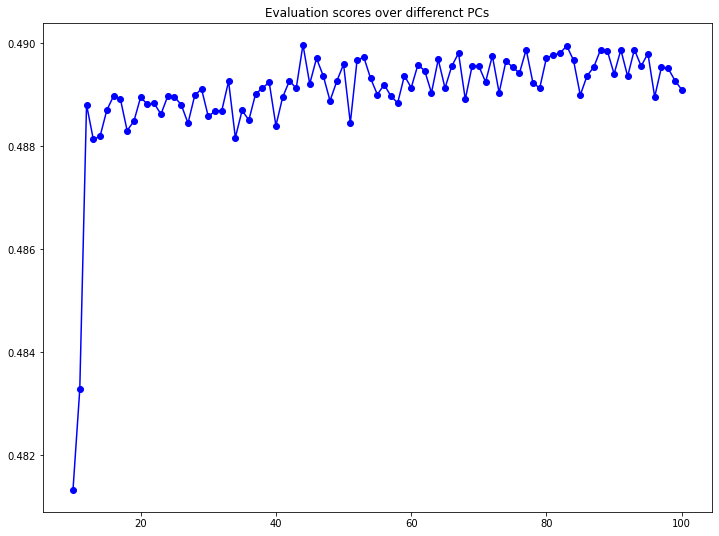

In [ ]:
# Evaluation over different PCs
pcs_scores = []
for i in range(10,101):
  pca = PCA(n_components=i)
  extend_data_pca = pca.fit_transform(data.T) 

  kmeans_pca = KMeans(n_clusters=5, random_state=9, init='random')
  kmeans_pca.fit(extend_data_pca)
  kpredict_pca=kmeans_pca.predict(extend_data_pca)
  score = adjusted_rand_score(data_label, kmeans_pca.labels_)
  pcs_scores.append([i,score])

pcs_scores = np.array(pcs_scores)
x=pcs_scores[:,0]
y=pcs_scores[:,1]

plt.figure(figsize=(12, 9));
plt.plot(x, y, 'o-', color='blue')
plt.title('Evaluation scores over differenct PCs')
plt.show()

We can see that the overall evaluations with different PCs larger than 12 perform similar.

In [ ]:
# imputation
def imputation(data_new, labels):
  feature_means = {}

  for label in np.unique(labels):
    feature_means[label] = []

    for exp in range(data_new.T.shape[0]):
      if labels[exp] == label:
        tmp = []
        for fe in range(data_new.T.shape[1]):
          tmp.append(data_new.T[exp, fe])
        feature_means[label].append(tmp) 

    feature_means[label] = np.array(feature_means[label])
    means = np.mean(feature_means[label], axis=0)

    for i in range(data_new.shape[0]):
      row_mean = means[i]
      for j in range(data_new.shape[1]):
        if data_new[i,j] == 0:
          data_new[i,j] = row_mean
  
  return data_new
  
def bestResultWithPCA(data):
  data = preprocessing.scale(data,axis=1)
  pca = PCA(n_components=20)
  extend_data_pca = pca.fit_transform(data.T) 

  kmeans_pca = KMeans(n_clusters=5, random_state=9, init='random')
  kmeans_pca.fit(extend_data_pca)
  kpredict_pca=kmeans_pca.predict(extend_data_pca)

  with open('kmeans_labels_pca_imputation.csv', 'w') as file:
    for label in kmeans_pca.labels_:
      file.write(str(label) + '\n')

def bestResultWithAuto(data):
  data = preprocessing.scale(data,axis=1)
  with tf.Session() as sess:
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    extend_data_auto = sess.run(encoder_op, feed_dict={X: data.T})

  kmeans_auto = KMeans(n_clusters=5, random_state=9, init='random')
  kmeans_auto.fit(extend_data_auto)
  kpredict_auto=kmeans_auto.predict(extend_data_auto)

  with open('kmeans_labels_auto_imputation.csv', 'w') as file:
    for label in kmeans_auto.labels_:
      file.write(str(label) + '\n')


data_new = imputation(data_ori, kmeans2_pca.labels_)

In [ ]:
bestResultWithPCA(data_new)
bestResultWithAuto(data_new)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


## Results

Show tables comparing your methods to the baselines.

What about these results surprised you? Why?

Did your models over- or under-fit? How can you tell? What did you do to address these issues?

What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?  

In [ ]:
# Show plots or visualizations of your evaluation metric(s) on the train and test sets.
#   What do these plots show about over- or under-fitting?
#   You may borrow from how we visualized results in the Lab homeworks.
#   Are there aspects of your results that are difficult to visualize? Why?

In [ ]:
import umap
reducer = umap.UMAP()
reducer.fit(extend_data_pca)
umap_embedding = reducer.transform(extend_data_pca)

In [ ]:
import pandas as pd
umap_embedding = pd.DataFrame(umap_embedding)
umap_embedding = umap_embedding.rename(columns={0:"UMAP_1",1:"UMAP_2"})

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


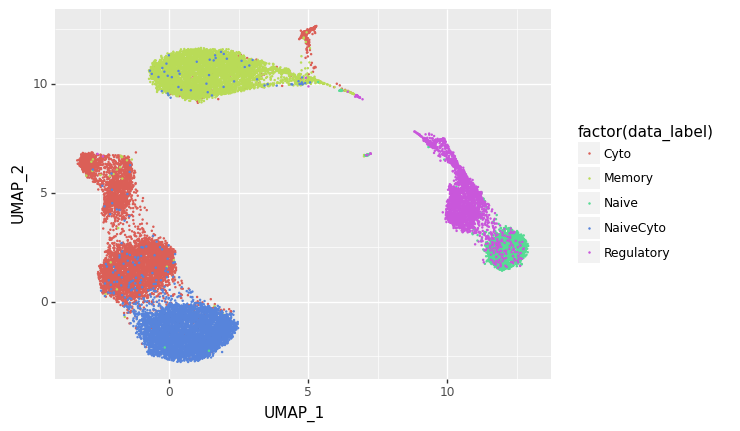

<ggplot: (8766112596151)>

In [ ]:
## Original Label Plot for UMAP created based on PCA
from plotnine import *
gg = ggplot(umap_embedding)
gg = gg + geom_point(aes('UMAP_1','UMAP_2',color = 'factor(data_label)'),size = 0)
gg

In [ ]:
auto_embedding = pd.DataFrame(extend_data_auto[:,[0,1]])
auto_embedding = auto_embedding.rename(columns={0:"AUTO_1",1:"AUTO_2"})

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


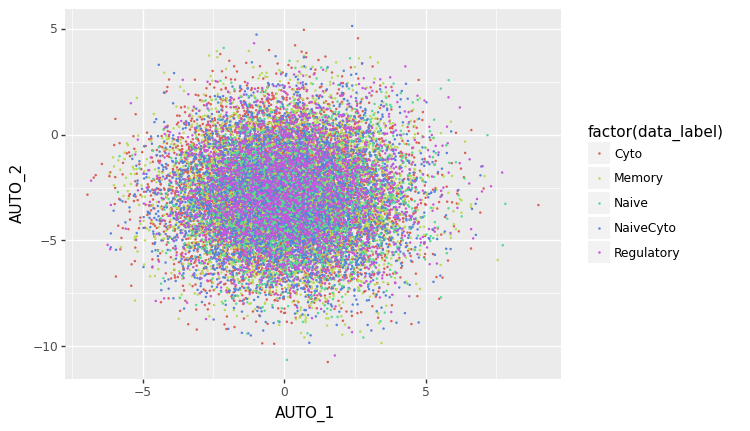

<ggplot: (8766112333674)>

In [ ]:
## Original Label Plot for UMAP created based on autoencoder
from plotnine import *
gg = ggplot(auto_embedding)
gg = gg + geom_point(aes('AUTO_1','AUTO_2',color = 'factor(data_label)'),size = 0)
gg

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


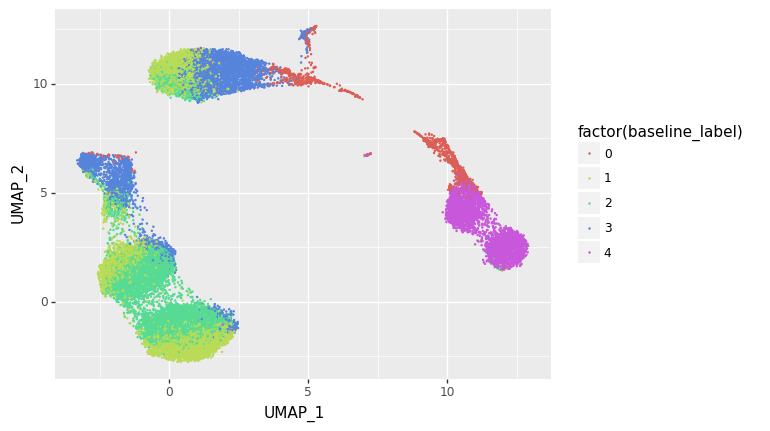

<ggplot: (8766113345586)>

In [ ]:
## Baseline Kmeans Cluster Result for UMAP
baseline_label = kmeans.labels_
from plotnine import *
gg = ggplot(umap_embedding)
gg = gg + geom_point(aes('UMAP_1','UMAP_2',color = 'factor(baseline_label)'),size = 0)
gg

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


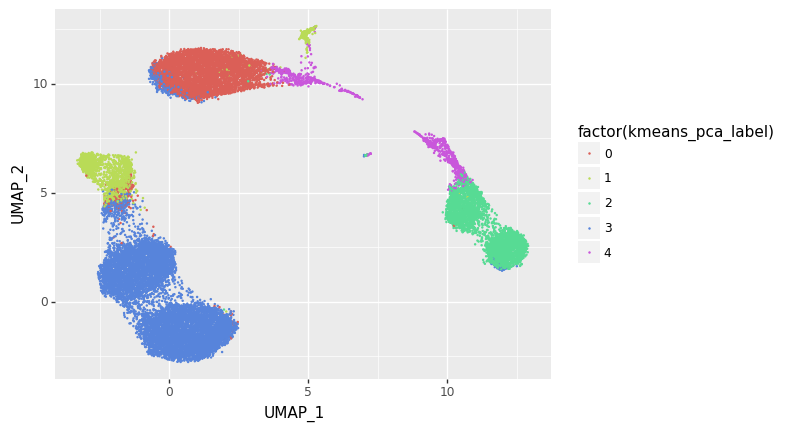

<ggplot: (8766111926690)>

In [ ]:
## Kmeans Cluster Result for UMAP created based on PCA
kmeans_pca_label = kmeans2_pca.labels_
from plotnine import *
gg = ggplot(umap_embedding)
gg = gg + geom_point(aes('UMAP_1','UMAP_2',color = 'factor(kmeans_pca_label)'),size = 0)
gg

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


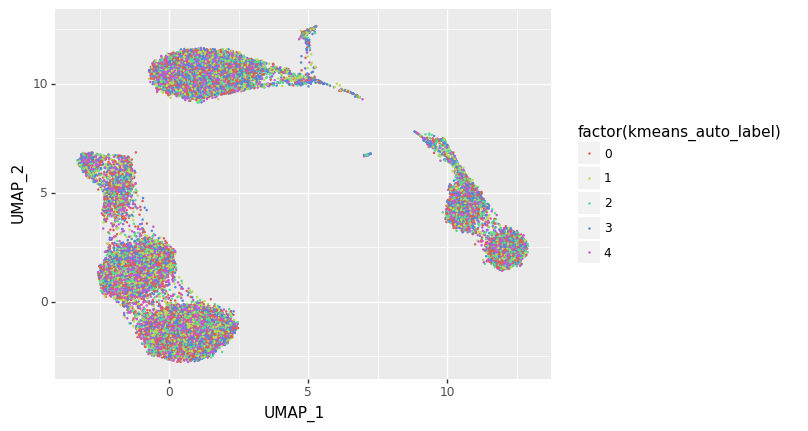

<ggplot: (8766111925245)>

In [ ]:
## Kmeans Cluster Result for UMAP created based on PCA
kmeans_auto_label = kmeans2_auto.labels_
from plotnine import *
gg = ggplot(umap_embedding)
gg = gg + geom_point(aes('UMAP_1','UMAP_2',color = 'factor(kmeans_auto_label)'),size = 0)
gg

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


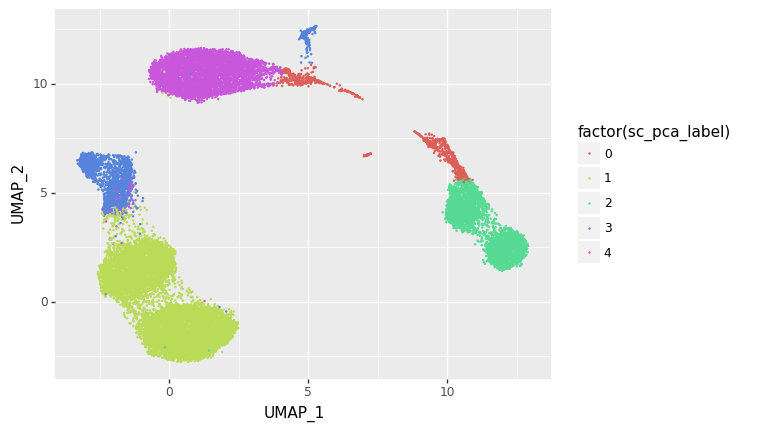

<ggplot: (8766101266801)>

In [ ]:
## Spectral Cluster Result for UMAP created based on PCA
sc_pca_label = spectral_pca_labels
from plotnine import *
gg = ggplot(umap_embedding)
gg = gg + geom_point(aes('UMAP_1','UMAP_2',color = 'factor(sc_pca_label)'),size = 0)
gg

/usr/local/lib/python3.6/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


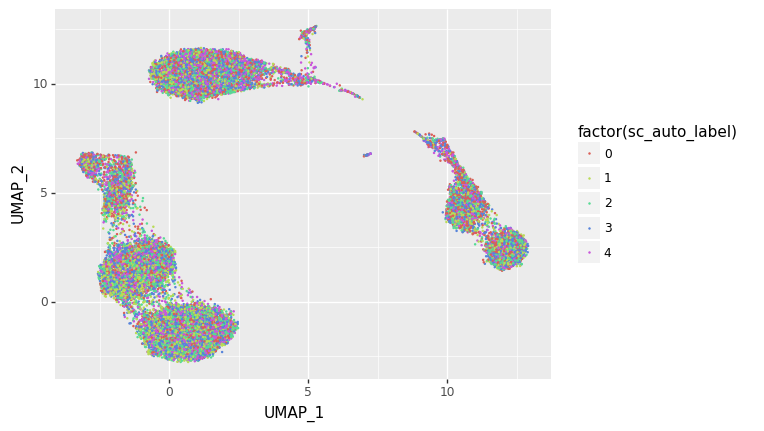

<ggplot: (8766110665743)>

In [ ]:
## Spectral Cluster Result for UMAP created based on Autoencoder
sc_auto_label = spectral_auto_labels
from plotnine import *
gg = ggplot(umap_embedding)
gg = gg + geom_point(aes('UMAP_1','UMAP_2',color = 'factor(sc_auto_label)'),size = 0)
gg

Wilcoxin Test Based on Imputation

In [ ]:
data_new_2 = data_new[:,np.where(kmeans2_pca.labels_ == 2)]
data_new_3 = data_new[:,np.where(kmeans2_pca.labels_ == 3)]

In [ ]:
hvg_index = []
from scipy.stats import wilcoxon
for gene in range(data_new_2.shape[0]):
    _,p = wilcoxon(data_new_2[gene],data_new_3[gene])
    if p < 0.05:
      hvg_index.append(gene)

Based on the imputation result, we did wilcoxin test between clusters like memory and regulatory. We find CD4 gene is inside.

# Discussion

## What you've learned

*Note: you don't have to answer all of these, and you can answer other questions if you'd like. We just want you to demonstrate what you've learned from the project.*

What concepts from lecture/breakout were most relevant to your project? How so?\
Ans: Lecture 15 Clustering and Lecture 24 Dimentionality Reduction

What aspects of your project did you find most surprising?\
Ans: Spectral Clustering not performs better than Kmeans. 

What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?\
Ans: Before implementing machine learning method, we should always remember to visualize and take pre-processing for the data set fist because it have relatively large influence on machine learning performance.

What was the most helpful feedback you received during your presentation? Why?\
Ans: All feedbacks we have got are very helpful to us, especially from Omar Ahmed group and Jeff Rufolo group. Thanks very much!

If you had two more weeks to work on this project, what would you do next? Why?\
Ans: If we had two more weeks to work on this project, we would like to implement the K means by hand, instead of using package directly. In this case, it may be more helpful for us to understand the principle of Kmeans which is the most popular unsupervised machine learning method. Besides, we have only make analysis about the evaluation over different PCs based on PCA, not on Autoencoder, because it will take long time to adjust autoencoder's network structure to get a satisfactory dimensional reduction. So, if we had more time, we would like to change autoencoder structure and test with the different results from dimensional reduction.